## 2. Pixel binning
In this step, we perform pixel binning to optimize the S/N ratio of the spatially resolved SEDs in the galaxy. The S/N thresholds can be set to multiple bands (i.e., not limited to a single band). Beside this, the pixel binning scheme in piXedfit considers similarity in shape of the SEDs of individual pixels. Pixel binning can be performed using function `piXedfit.piXedfit_bin.pixel_binning`. The input can be in the form of both the photometric and spectrophotometric data cubes. In this tutorial, we will try pixel binning on the spectrophotometric data cube that we have produced in the previus step.    

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1. Run pixel binning

In [2]:
from piXedfit.piXedfit_bin import pixel_binning

In [3]:
fits_fluxmap = "fluxmap_m51.fits"
ref_band = 4          # SDSS/r
Dmin_bin = 5          # in pixel
redc_chi2_limit = 4.0

# Set S/N thresholds. Here we try S/N=20 in 7 bands of GALEX and SDSS
nbands = 23                # number of photometric filters in our data cube
SNR = np.zeros(nbands)
SNR[0:7] = 20.0
    
name_out_fits = "pixbin_%s" % fits_fluxmap
pixel_binning(fits_fluxmap, ref_band=ref_band, Dmin_bin=Dmin_bin, SNR=SNR, 
              redc_chi2_limit=redc_chi2_limit, name_out_fits=name_out_fits)

Bins: 323 ==> accumulated pixels: 3013/3013
Number of bins: 323


'pixbin_fluxmap_m51.fits'

If you get the pixel binning process stack, please try to change the parameters, especially the S/N thresholds and the set filters that you assigned with those S/N ratios.

### 2.2. Check the binning result

In [4]:
hdu = fits.open("pixbin_fluxmap_m51.fits")
hdu.info()
header = hdu[0].header
print (header)

Filename: pixbin_fluxmap_m51.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  BIN_MAP       1 PrimaryHDU      45   (141, 141)   float64   
  1  BIN_FLUX      1 ImageHDU         9   (141, 141, 23)   float64   
  2  BIN_FLUXERR    1 ImageHDU         9   (141, 141, 23)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  141                                                  NAXIS2  =                  141                                                  EXTEND  =                    T                                                  NFILTERS=                   23                                                  REFBAND =                    4                                                  RA      =        202.469649065                           

In [5]:
# get number of bins, both in photometric and spectrophotometric data cubes
nbins = int(header['nbins'])

# get set of filters
nbands = int(header['nfilters'])
filters = []
for bb in range(0,nbands):
    str_temp = 'fil%d' % bb
    filters.append(header[str_temp])
    
# get central wavelengths of filters
from piXedfit.utils.filtering import cwave_filters
photo_wave = cwave_filters(filters)

# spatial bin maps
binmap = hdu['bin_map'].data

# unit of flux
unit_flux = float(header['unit'])

# allocate arrays for photometric and spectrophotometric SEDs of spatial bins
bin_flux = np.zeros((nbins,nbands))
bin_flux_err = np.zeros((nbins,nbands))

for bb in range(0,nbins):
    bin_id = bb + 1
    rows, cols = np.where(binmap==bin_id)
    bin_flux[bb] = hdu['bin_flux'].data[:,rows[0],cols[0]]*unit_flux
    bin_flux_err[bb] = hdu['bin_fluxerr'].data[:,rows[0],cols[0]]*unit_flux
hdu.close()

### 2.2.1. Plot bin map

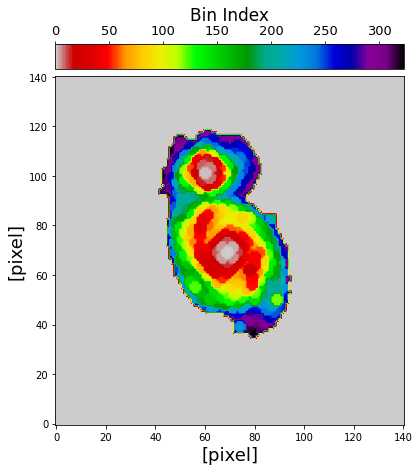

In [6]:
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable

# plot spatial bin map
fig1 = plt.figure(figsize=(7,7))
f1 = plt.subplot()
plt.xlabel("[pixel]", fontsize=18)
plt.ylabel("[pixel]", fontsize=18)
    
im = plt.imshow(binmap, origin='lower', cmap='nipy_spectral_r', vmin=0, vmax=nbins)

divider = make_axes_locatable(f1)
cax2 = divider.append_axes("top", size="7%", pad="2%")
cb = fig1.colorbar(im, cax=cax2, orientation="horizontal")
cax2.xaxis.set_ticks_position("top")
cax2.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=13)
cb.set_label('Bin Index', fontsize=17)

### 2.2.2. Plot SEDs of some spatial bins

Some spatial bins, especially those residing in the inner region, have spectrophotometric SED, while the other spatial bins have only photometric SED.

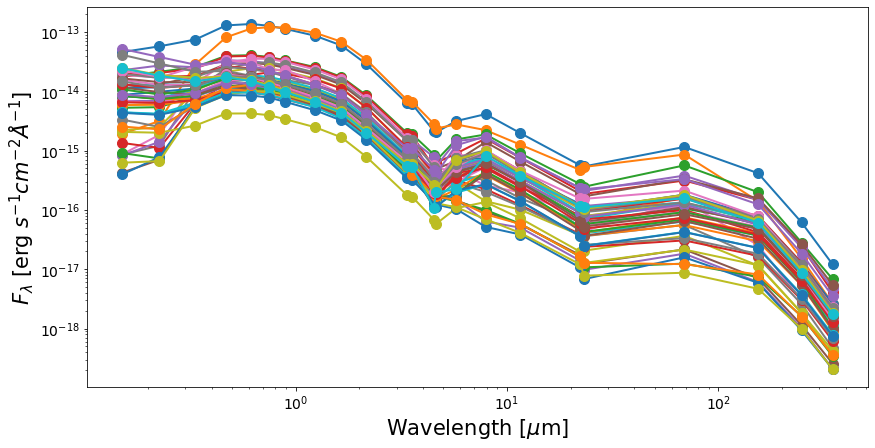

In [7]:
fig1 = plt.figure(figsize=(14,7))
f1 = plt.subplot()   
f1.set_yscale('log')
f1.set_xscale('log')
plt.setp(f1.get_yticklabels(), fontsize=14)
plt.setp(f1.get_xticklabels(), fontsize=14)
plt.xlabel(r'Wavelength [$\mu$m]', fontsize=21)
plt.ylabel(r'$F_{\lambda}$ [erg $s^{-1}cm^{-2}\AA^{-1}$]', fontsize=21)
    
for ii in range(0,50):
    plt.errorbar(photo_wave/1e+4, bin_flux[ii], yerr=bin_flux_err[ii], markersize=10, fmt='-o', lw=2)

### 2.2.3. Check the S/N ratios of the spatial bins

In [9]:
bin_SNR = np.zeros((nbands,nbins))
for bb in range(0,nbands):
    bin_SNR[bb] = bin_flux[:,bb]/bin_flux_err[:,bb]

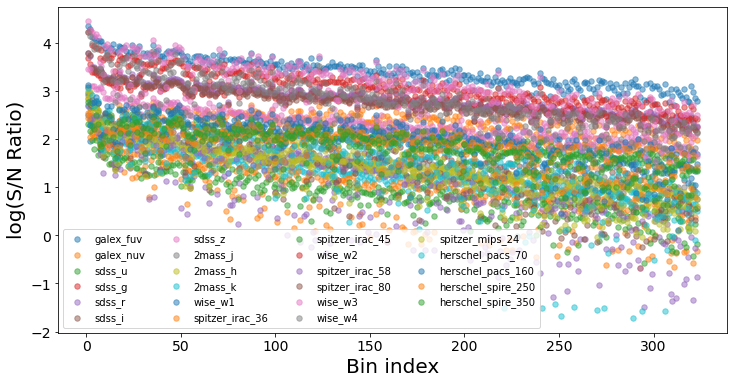

In [14]:
fig1 = plt.figure(figsize=(12,6))
f1 = plt.subplot()
plt.setp(f1.get_yticklabels(), fontsize=14, visible=True)
plt.setp(f1.get_xticklabels(), fontsize=14, visible=True)
plt.xlabel(r"Bin index", fontsize=20)
plt.ylabel(r"log(S/N Ratio)", fontsize=20)

bin_ids = np.arange(1,nbins+1)

for bb in range(0,nbands):
    plt.scatter(bin_ids, np.log10(bin_SNR[bb]), s=30, alpha=0.5, label='%s' % filters[bb])

plt.legend(fontsize=10, ncol=4, loc=3)